In [1]:
import pandas as pd
import numpy as np
import requests
import re
import csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.image as mpimg

#  1.1 Общий контекст исследования

In [2]:
# Датасет по количеству жителей по всем населенным пунктам РФ (платформа ИНИД).
# https://data-in.ru/data-catalog/datasets/160/
settlements = pd.read_csv('Data/INID/List_cities&towns/settlements_12032021/data.csv', 
                    index_col=0, 
                    dtype={'oktmo': 'object'})
settlements

,region,municipality,settlement,type,population,children,latitude_dms,longitude_dms,latitude_dd,longitude_dd,oktmo,dadata,rosstat
id,,,,,,,,,,,,,
0,Орловская область,Болховский,Колонтаева,д,0,0,53.22.07,035.54.36,53.368611,35.910000,54604416131,0,1
1,Республика Крым,Алушта,Пушкино,с,273,0,44.35.45,034.20.27,44.595833,34.340833,35703000181,0,1
2,Липецкая область,Лев-Толстовский район,Барятино,с,7,1,53.15.46,039.30.14,53.262778,39.503889,42636412121,0,1
3,Тверская область,Селижаровский район,Хилово,д,2,0,56.54.20,033.25.09,56.905556,33.419167,28650432191,0,1
4,Томская область,Парабельский район,Басмасово,д,6,0,58.38.12,082.02.40,58.636667,82.044444,69644440111,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155916,Ульяновская область,Вешкаймский район,Ребровка,д,0,0,53.59.12,046.48.35,53.986667,46.809722,73607440131,0,1
155917,Псковская область,Палкинский район,Шадрица,д,1,0,57.29.03,028.08.48,57.484167,28.146667,58637423446,0,1
155918,Псковская область,Себежский район,Овчинниково,д,0,0,56.19.48,028.26.17,56.330000,28.438056,58654101351,0,1


In [3]:
# Численность населения в данном датасете на 1.5 млн больше, чем показывает Росстат (146 171,0 тыс.чел.).
# В части общей численности буду ориентироваться на данные Росстата, 
# из датасета ИНИД возьму только данные по городам.
settlements['population'].sum()

147624669

In [4]:
# Посмотрим, какие типы населенных пунктов есть в списке.
settlements.groupby('type').agg({'region': 'count', 'population': 'sum'})

,region,population
type,,
c,4,193
x,1,26
аал,52,10856
автодорога,1,0
арбан,12,1392
аул,197,222551
высел,53,1758
г,1150,99938388
городок,7,13130


In [5]:
# Общая численность городов (тип "г").
settlements[settlements['type']=='г']['population'].sum()

99938388

In [6]:
# Выделим города в отдельный список.
cities_types = settlements[settlements['type']=='г'][['region', 'settlement', 'population']]

# Данные о соотношении сельского и городского населения используем по данным Росстата (25% - село, 75% - город),
# а численность населения городов оставим по данным датасета settlements 
# (будем использовать для классификации городов по признаку численности: миллионники, крупнейшие и т.д.).
# Рассчитаем численность сельского населения (25%), если городского - 99938388 чел. (75%):
# 99938388 * 25% / 75% = 33312796.
# Численность сельского населения добавим одной строкой в конце датасета cities_types.
cities_types = cities_types.append({'region': 'Сельские жители', 
                                    'settlement': 'Сельские жители', 
                                    'population': (99938388*0.25/0.75)}, ignore_index=True)

cities_types

,region,settlement,population
0,Республика Саха (Якутия),Верхоянск,1095.0
1,Калининградская область,Славск,4330.0
2,Республика Татарстан,Мензелинск,16968.0
3,Воронежская область,Семилуки,26805.0
4,Калининградская область,Черняховск,36255.0
...,...,...,...
1146,Томская область,Асино,24141.0
1147,Республика Татарстан,Мамадыш,15528.0
1148,Москва,Москва,1776789.0
1149,Иркутская область,Зима,30818.0


In [33]:
# Классификация населенных пунктов по количеству населения.
def classification(row):
    if row['region'] == 'Сельские жители':
        return 'Сельские населенные пункты'
    else:
        if row['population']>1000000:
            return 'Миллионники (>1млн)'
        elif row['population']>500000:
            return 'Крупнейшие города (500тыс-1млн)'
        elif row['population']>100000:
            return 'Большие города (100-500тыс)'
        elif row['population']>50000:
            return 'Средние города (50-100тыс)'
        else:
            return 'Малые города (<50тыс)'

In [34]:
# применим классификацию к списку населенных пунктов
cities_types['class'] = cities_types.apply(classification, axis=1)
cities_types

,region,settlement,population,class
0,Республика Саха (Якутия),Верхоянск,1095,Малые города (<50тыс)
1,Калининградская область,Славск,4330,Малые города (<50тыс)
2,Республика Татарстан,Мензелинск,16968,Малые города (<50тыс)
3,Воронежская область,Семилуки,26805,Малые города (<50тыс)
4,Калининградская область,Черняховск,36255,Малые города (<50тыс)
...,...,...,...,...
1146,Томская область,Асино,24141,Малые города (<50тыс)
1147,Республика Татарстан,Мамадыш,15528,Малые города (<50тыс)
1148,Москва,Москва,1776789,Миллионники (>1млн)
1149,Иркутская область,Зима,30818,Малые города (<50тыс)


In [35]:
# Сгруппируем города по введенной выше классификации.
cities_types.groupby('class').sum()['population']

class
Большие города (100-500тыс)        31317230
Крупнейшие города (500тыс-1млн)    17026685
Малые города (<50тыс)              16113094
Миллионники (>1млн)                24451725
Сельские населенные пункты         33312796
Средние города (50-100тыс)         11029654
Name: population, dtype: int64

In [36]:
# Создадим сводную таблицу по типам городов.
cities_types_pt = cities_types.pivot_table(index='class', values='population', aggfunc='sum').reset_index()

# Добавим к своду столбцы с долями, населением в миллионах и порядковым номером по размеру городов
# (от 1 до 6: миллионники - 6, село - 1).
cities_types_pt['%population'] = round((cities_types_pt['population']/cities_types_pt['population'].sum())*100, 0)
cities_types_pt['population_mln'] = cities_types_pt['population']/1000000
cities_types_pt.insert(0, 'ranking', [4, 5, 2, 6, 1, 3])

# Отсортируем по категории города: от 
cities_types_pt.sort_values('ranking', ascending=False, inplace=True)

# изменим тип столбца %population на integer, чтобы на рисунке % отображался без десятичных долей
cities_types_pt = cities_types_pt.astype({'%population': 'int32'})
cities_types_pt

,ranking,class,population,%population,population_mln
3,6,Миллионники (>1млн),24451725,18,24.451725
1,5,Крупнейшие города (500тыс-1млн),17026685,13,17.026685
0,4,Большие города (100-500тыс),31317230,24,31.317230
5,3,Средние города (50-100тыс),11029654,8,11.029654
2,2,Малые города (<50тыс),16113094,12,16.113094
4,1,Сельские населенные пункты,33312796,25,33.312796


(0.0, 100.0, 0.0, 100.0)

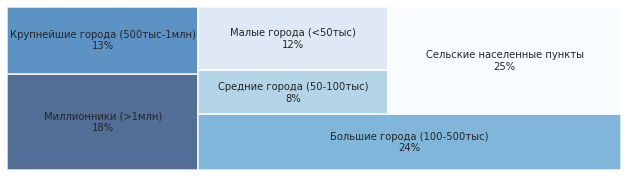

In [39]:
# Визуализация древовидной карты (https://habr.com/ru/post/468295/).

import squarify 

plt.figure(figsize=(11,3))

mini=min(cities_types_pt['ranking'])
maxi=max(cities_types_pt['ranking'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [plt.cm.Blues(norm(value)) for value in cities_types_pt['ranking']]

labels = cities_types_pt.apply(lambda x: str(x[1]) + '\n' + str(x[3]) + '%', axis=1)

squarify.plot(label=labels, 
              sizes=cities_types_pt['population_mln'], 
              color=colors, 
              alpha=.7, 
              edgecolor='white', 
              linewidth=2, 
             text_kwargs={'fontsize':10})

plt.axis('off')

## 1.3 Данные

In [8]:
# Основной датасет по социоэкономическому развитию регионов.
# Собран по данным Росстат (https://rosstat.gov.ru/folder/210/document/13206).

cities = pd.read_excel('combined_data.xlsx', sheet_name='cities', usecols='A:W')
cities

,region1,region2,year,region_capital,name,population_thnds,births_on1thnd,deaths_on1thnd,working_age_thnds,employment_thnds,...,firms,mining_mlnRUB,manufacturing_mlnRUB,electricity_mlnRUB,utilities_mlnRUB,accommodations_th.sq.m.,retail_mlnRUB,migration_persons,rating_urban,rating_SME
0,ЦФО,Белгородская область,2017,1,Белгород,391.6,9.9,10.4,228.9,107.2,...,20948,74.9,72839.8,21088.1,1498.6,197.1,39648.9,613,0,0
1,ЦФО,Брянская область,2017,1,Брянск,424.0,10.9,13.7,237.2,119.6,...,12177,0.0,75732.7,11953.1,3754.6,405.6,42363.4,130,0,0
2,ЦФО,Владимирская область,2017,1,Владимир,359.5,10.3,12.6,205.3,105.0,...,14076,0.0,72428.5,20339.2,3150.7,182.8,41721.6,1676,0,0
3,ЦФО,Воронежская область,2017,1,Воронеж,1047.5,11.1,12.4,611.9,260.7,...,43940,0.0,150169.5,33150.6,6984.0,1110.4,103850.7,9100,0,0
4,ЦФО,Ивановская область,2017,1,Иваново,406.1,9.8,14.3,230.3,81.9,...,21832,0.0,35076.4,18339.7,1229.4,181.4,36769.1,991,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,ЦФО,Московская область,2019,0,Сергиев Посад,100.3,14.3,17.2,53.3,25.5,...,3755,0.0,14164.9,1888.4,663.3,80.2,19258.7,-1342,181,2
539,ЦФО,Московская область,2019,0,Серпухов,126.3,10.7,15.1,71.2,21.3,...,2545,0.0,23843.3,2133.6,0.0,93.3,17143.1,1925,212,4
540,ЦФО,Московская область,2019,0,Химки,259.6,6.1,9.3,157.8,96.0,...,11499,0.0,25770.3,3747.2,2079.0,414.6,136967.7,5606,217,4
541,ЦФО,Московская область,2019,0,Щелково,126.1,18.0,12.5,68.1,30.9,...,3620,0.0,88571.8,1113.6,1663.3,120.6,23692.7,589,197,4


In [9]:
# Краткое описание столбцов:
# region1 - Федеральные округа.
# region2 - Регионы РФ.
# year - Год отчетности.
# region_capital - Является ли город столицей региона (1 – да, 0 – нет).
# name - Название города.
# population_thnds - Численность населения  (оценка на конец года), тыс.чел.
# births_on1thnd - Число родившихся на 1000 человек населения.
# deaths_on1thnd - Число умерших на 1000 человек населения.
# working_age_thnds - Количество людей в трудоспособном возрасте.
# employment_thnds - Среднегодовая численность работников организаций, тыс.чел.
# salary_RUBmnth - Среднемесячная номинальная начисленная заработная плата работников организаций, руб.
# sq.m_per_citizen - Общая площадь жилых помещений, приходящаяся в среднем на 1 жителя (на конец года), м2.
# investments_mlnRUB - Инвестиции в основной капитал, млн руб.
# firms - Число предприятий и организаций (на конец года; по данным государственной регистрации).
# mining_mlnRUB - Добыча полезных ископаемых, млн руб.
# manufacturing_mlnRUB - Обрабатывающие производства,  млн руб.
# electricity_mlnRUB - Обеспечение электрической энергией, газом и паром; кондиционирование воздуха,  млн руб.
# utilities_mlnRUB - Водоснабжение; водоотведение, организация сбора и утилизации отходов и т.д., млн руб.
# accommodations_th.sq.m. - Ввод в действие жилых домов, тыс. м2 общей площади жилых помещений.
# retail_mlnRUB - Оборот розничной торговли (в фактически действовавших ценах), млн руб.
# migration_persons - Миграционный прирост, убыль (-)  населения, человек.
# rating_urban - Значение индекса качества городской среды.
# rating_SME - Балл в зависимости от количества МСП и условий для их развития (4-макс.развитие, 1-мин.развитие).

cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region1                  543 non-null    object 
 1   region2                  543 non-null    object 
 2   year                     543 non-null    int64  
 3   region_capital           543 non-null    int64  
 4   name                     543 non-null    object 
 5   population_thnds         543 non-null    float64
 6   births_on1thnd           543 non-null    float64
 7   deaths_on1thnd           543 non-null    float64
 8   working_age_thnds        543 non-null    float64
 9   employment_thnds         543 non-null    float64
 10  salary_RUBmnth           543 non-null    float64
 11  sq.m_per_citizen         543 non-null    float64
 12  investments_mlnRUB       543 non-null    float64
 13  firms                    543 non-null    int64  
 14  mining_mlnRUB            5

## 1.4 Обработка данных

In [4]:
# Рассчитаем показатели, необходимые для аналитики.

# Естественный прирост населения=рождения-смерти.
cities['population_change'] = cities['births_on1thnd'] - cities['deaths_on1thnd']

# Объем введенного жилья в кв.м. на 1000 жителей.
# accommod_on1thnd - ввод жилья в кв.м. на 1000 жителей
cities['accommod_on1thnd'] = (1000 * cities['accommodations_th.sq.m.'] / cities['population_thnds']).round(decimals=1)

# Миграционный прирост/убыль, человек на 1000 жителей.
# migration_on1thnd - миграционный прирост/убыль человек на 1000 жителей
cities['migration_on1thnd'] = (cities['migration_persons'] / cities['population_thnds']).round(decimals=1)

# Объем инвестиций на душу населения в тыс.руб./чел.
# inv_thnds/sprsn - инвестиции в основной капитал, тыс.руб. на человека
cities['inv_thnds/prsn'] = (cities['investments_mlnRUB'] / cities['population_thnds']).round(decimals=1)

# Объем промышленного производства на душу населения в тыс.руб./чел.
# industry_thnds/prsn - промышленное производство, тыс.руб. на человека
cities['industry_thnds/prsn'] = ((cities['mining_mlnRUB'] 
                                  + cities['manufacturing_mlnRUB'] 
                                  + cities['electricity_mlnRUB'] 
                                  + cities['utilities_mlnRUB']) / cities['population_thnds']).round(decimals=1)

# Количество зарегистрированных компаний на 1000 жителей.
# firms_on1thnd - количество компаний на 1000 жителей
cities['firms_on1thnd'] = (cities['firms'] / cities['population_thnds']).round()

# Оборот розничной торговли, тыс.руб./чел.
# retail_thnds/prsn - оборот розничной торговли (в фактически действовавших ценах), тыс.руб. на человека
cities['retail_thnds/prsn'] = (cities['retail_mlnRUB'] / cities['population_thnds']).round(decimals=1)

# Уровень занятости в трудоспособном возрасте.
# employment_% - employment rate, уровень занятости в трудоспособном возрасте (16 - 60/65 лет).
cities['employment_%'] = (100 * cities['employment_thnds'] / cities['working_age_thnds']).round(decimals=1)

cities

,region1,region2,year,region_capital,name,population_thnds,births_on1thnd,deaths_on1thnd,working_age_thnds,employment_thnds,...,rating_urban,rating_SME,population_change,accommod_on1thnd,migration_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,employment_%
0,ЦФО,Белгородская область,2017,1,Белгород,391.6,9.9,10.4,228.9,107.2,...,0,0,-0.5,503.3,1.6,47.7,243.9,53.0,101.2,46.8
1,ЦФО,Брянская область,2017,1,Брянск,424.0,10.9,13.7,237.2,119.6,...,0,0,-2.8,956.6,0.3,41.0,215.7,29.0,99.9,50.4
2,ЦФО,Владимирская область,2017,1,Владимир,359.5,10.3,12.6,205.3,105.0,...,0,0,-2.3,508.5,4.7,59.5,266.8,39.0,116.1,51.1
3,ЦФО,Воронежская область,2017,1,Воронеж,1047.5,11.1,12.4,611.9,260.7,...,0,0,-1.3,1060.0,8.7,86.5,181.7,42.0,99.1,42.6
4,ЦФО,Ивановская область,2017,1,Иваново,406.1,9.8,14.3,230.3,81.9,...,0,0,-4.5,446.7,2.4,19.8,134.6,54.0,90.5,35.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,ЦФО,Московская область,2019,0,Сергиев Посад,100.3,14.3,17.2,53.3,25.5,...,181,2,-2.9,799.6,-13.4,19.7,166.7,37.0,192.0,47.8
539,ЦФО,Московская область,2019,0,Серпухов,126.3,10.7,15.1,71.2,21.3,...,212,4,-4.4,738.7,15.2,34.1,205.7,20.0,135.7,29.9
540,ЦФО,Московская область,2019,0,Химки,259.6,6.1,9.3,157.8,96.0,...,217,4,-3.2,1597.1,21.6,324.0,121.7,44.0,527.6,60.8
541,ЦФО,Московская область,2019,0,Щелково,126.1,18.0,12.5,68.1,30.9,...,197,4,5.5,956.4,4.7,206.0,724.4,29.0,187.9,45.4


In [5]:
# Введем классификацию городов по численности жителей.
def classification_1(row):
    if row['population_thnds']>1000:
        return 'Миллионники (>1млн)'
    elif row['population_thnds']>500:
        return 'Крупнейшие города (500тыс-1млн)'
    elif row['population_thnds']>100:
        return 'Большие города (100-500тыс)'
    elif row['population_thnds']>50:
        return 'Средние города (50-100тыс)'
    else:
        return 'Малые города (<50тыс)'

In [6]:
# Применим функцию к датасету.
cities['class_1'] = cities.apply(classification_1, axis=1)
cities

,region1,region2,year,region_capital,name,population_thnds,births_on1thnd,deaths_on1thnd,working_age_thnds,employment_thnds,...,rating_SME,population_change,accommod_on1thnd,migration_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,employment_%,class_1
0,ЦФО,Белгородская область,2017,1,Белгород,391.6,9.9,10.4,228.9,107.2,...,0,-0.5,503.3,1.6,47.7,243.9,53.0,101.2,46.8,Большие города (100-500тыс)
1,ЦФО,Брянская область,2017,1,Брянск,424.0,10.9,13.7,237.2,119.6,...,0,-2.8,956.6,0.3,41.0,215.7,29.0,99.9,50.4,Большие города (100-500тыс)
2,ЦФО,Владимирская область,2017,1,Владимир,359.5,10.3,12.6,205.3,105.0,...,0,-2.3,508.5,4.7,59.5,266.8,39.0,116.1,51.1,Большие города (100-500тыс)
3,ЦФО,Воронежская область,2017,1,Воронеж,1047.5,11.1,12.4,611.9,260.7,...,0,-1.3,1060.0,8.7,86.5,181.7,42.0,99.1,42.6,Миллионники (>1млн)
4,ЦФО,Ивановская область,2017,1,Иваново,406.1,9.8,14.3,230.3,81.9,...,0,-4.5,446.7,2.4,19.8,134.6,54.0,90.5,35.6,Большие города (100-500тыс)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,ЦФО,Московская область,2019,0,Сергиев Посад,100.3,14.3,17.2,53.3,25.5,...,2,-2.9,799.6,-13.4,19.7,166.7,37.0,192.0,47.8,Большие города (100-500тыс)
539,ЦФО,Московская область,2019,0,Серпухов,126.3,10.7,15.1,71.2,21.3,...,4,-4.4,738.7,15.2,34.1,205.7,20.0,135.7,29.9,Большие города (100-500тыс)
540,ЦФО,Московская область,2019,0,Химки,259.6,6.1,9.3,157.8,96.0,...,4,-3.2,1597.1,21.6,324.0,121.7,44.0,527.6,60.8,Большие города (100-500тыс)
541,ЦФО,Московская область,2019,0,Щелково,126.1,18.0,12.5,68.1,30.9,...,4,5.5,956.4,4.7,206.0,724.4,29.0,187.9,45.4,Большие города (100-500тыс)


In [7]:
# Выделим качественные данные по городам в отдельный датафрейм, включая показатели рейтингов
# (индекс качества городской среды за 2019, развитость МСП на начало 2020)
# и численность за 2019 (как последний из рассматриваемых).
classes2019 = cities[cities['year']==2019][['year', 
                                            'population_thnds', 
                                            'rating_urban', 
                                            'rating_SME', 
                                            'region_capital', 
                                            'region1', 
                                            'region2', 
                                            'name', 
                                            'class_1']]
classes2019

,year,population_thnds,rating_urban,rating_SME,region_capital,region1,region2,name,class_1
34,2019,394.1,218,4,1,ЦФО,Белгородская область,Белгород,Большие города (100-500тыс)
35,2019,420.4,181,1,1,ЦФО,Брянская область,Брянск,Большие города (100-500тыс)
36,2019,359.4,180,2,1,ЦФО,Владимирская область,Владимир,Большие города (100-500тыс)
37,2019,1058.3,164,1,1,ЦФО,Воронежская область,Воронеж,Миллионники (>1млн)
38,2019,404.6,180,2,1,ЦФО,Ивановская область,Иваново,Большие города (100-500тыс)
...,...,...,...,...,...,...,...,...,...
538,2019,100.3,181,2,0,ЦФО,Московская область,Сергиев Посад,Большие города (100-500тыс)
539,2019,126.3,212,4,0,ЦФО,Московская область,Серпухов,Большие города (100-500тыс)
540,2019,259.6,217,4,0,ЦФО,Московская область,Химки,Большие города (100-500тыс)
541,2019,126.1,197,4,0,ЦФО,Московская область,Щелково,Большие города (100-500тыс)


In [9]:
# Количественные данные также выделим в отдельный датафрейм, чтобы рассчитать для них средние за 2017-2019гг.
# Предварительно группируем количественные данные по городам.

cities_growth = cities.groupby('name').mean()[['population_change', 
                                               'migration_on1thnd', 
                                               'accommod_on1thnd', 
                                               'inv_thnds/prsn', 
                                               'industry_thnds/prsn',  
                                               'firms_on1thnd', 
                                               'retail_thnds/prsn', 
                                               'salary_RUBmnth', 
                                               'employment_%', 
                                              'sq.m_per_citizen']].sort_values(by='migration_on1thnd', ascending=False).reset_index()
cities_growth

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,employment_%,sq.m_per_citizen
0,Мытищи,1.133333,43.400000,1622.933333,102.400000,783.233333,46.333333,553.200000,59082.300000,51.133333,28.900000
1,Красногорск,1.566667,42.266667,2977.200000,181.500000,412.833333,45.333333,301.666667,68119.666667,52.500000,35.266667
2,Долгопрудный,-0.266667,35.366667,1057.966667,44.033333,236.100000,32.000000,99.366667,74811.233333,26.700000,32.166667
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,18.333333,185.100000,56669.433333,18.533333,28.066667
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,38.333333,269.466667,65710.000000,72.333333,42.300000
...,...,...,...,...,...,...,...,...,...,...,...
176,Мурманск,-2.000000,-9.700000,41.100000,225.166667,347.300000,38.666667,134.066667,68016.033333,51.933333,24.133333
177,Сергиев Посад,-3.400000,-10.533333,833.433333,36.933333,143.366667,43.000000,180.966667,43938.933333,47.766667,34.433333
178,Находка,-3.566667,-10.666667,232.733333,113.400000,101.400000,32.000000,43.066667,51018.500000,40.166667,24.833333
179,Ухта,-1.300000,-13.933333,93.300000,323.966667,861.100000,20.333333,112.933333,62367.933333,51.666667,24.033333


In [10]:
# Соединим количественные данные из cities_growth с качественными данными из classes2019.

cities_growth = cities_growth.merge(classes2019, how='left', on='name').drop('year', axis=1)
cities_growth

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,employment_%,sq.m_per_citizen,population_thnds,rating_urban,rating_SME,region_capital,region1,region2,class_1
0,Мытищи,1.133333,43.400000,1622.933333,102.400000,783.233333,46.333333,553.200000,59082.300000,51.133333,28.900000,235.5,227,4,0,ЦФО,Московская область,Большие города (100-500тыс)
1,Красногорск,1.566667,42.266667,2977.200000,181.500000,412.833333,45.333333,301.666667,68119.666667,52.500000,35.266667,175.6,230,4,0,ЦФО,Московская область,Большие города (100-500тыс)
2,Долгопрудный,-0.266667,35.366667,1057.966667,44.033333,236.100000,32.000000,99.366667,74811.233333,26.700000,32.166667,116.0,225,4,0,ЦФО,Московская область,Большие города (100-500тыс)
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,18.333333,185.100000,56669.433333,18.533333,28.066667,507.4,204,3,0,ЦФО,Московская область,Крупнейшие города (500тыс-1млн)
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,38.333333,269.466667,65710.000000,72.333333,42.300000,137.2,177,4,0,ЦФО,Московская область,Большие города (100-500тыс)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Мурманск,-2.000000,-9.700000,41.100000,225.166667,347.300000,38.666667,134.066667,68016.033333,51.933333,24.133333,287.8,186,3,1,СЗФО,Мурманская область,Большие города (100-500тыс)
177,Сергиев Посад,-3.400000,-10.533333,833.433333,36.933333,143.366667,43.000000,180.966667,43938.933333,47.766667,34.433333,100.3,181,2,0,ЦФО,Московская область,Большие города (100-500тыс)
178,Находка,-3.566667,-10.666667,232.733333,113.400000,101.400000,32.000000,43.066667,51018.500000,40.166667,24.833333,146.0,160,2,0,ДФО,Приморский край,Большие города (100-500тыс)
179,Ухта,-1.300000,-13.933333,93.300000,323.966667,861.100000,20.333333,112.933333,62367.933333,51.666667,24.033333,113.7,187,4,0,СЗФО,Республика Коми,Большие города (100-500тыс)


In [11]:
# Описательная статистика.
cities_growth.describe()

,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,employment_%,sq.m_per_citizen,population_thnds,rating_urban,rating_SME,region_capital
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,-0.474217,2.621363,574.525414,86.281400,426.096501,29.307551,105.099263,44261.362615,43.799448,25.304972,432.943094,183.254144,2.563536,0.441989
std,4.454739,8.618989,440.496327,129.309353,589.277146,14.371803,70.154760,16120.503956,11.148155,4.346694,1035.084707,24.505363,1.287805,0.498001
min,-7.633333,-18.666667,0.000000,0.000000,0.000000,5.666667,0.933333,23375.200000,14.266667,13.466667,51.300000,106.000000,1.000000,0.000000
25%,-3.333333,-2.066667,304.033333,32.133333,141.966667,17.000000,67.433333,33640.500000,37.400000,23.300000,127.500000,168.000000,1.000000,0.000000
50%,-1.266667,1.100000,477.133333,52.766667,259.900000,27.333333,94.066667,39742.166667,43.933333,25.100000,225.900000,181.000000,3.000000,0.000000
75%,1.766667,5.133333,733.833333,100.433333,502.200000,39.333333,125.533333,48601.733333,50.333333,27.533333,439.100000,199.000000,4.000000,1.000000
max,17.733333,43.400000,2977.200000,1384.233333,4318.266667,76.333333,553.200000,111803.333333,74.666667,46.666667,12678.100000,283.000000,4.000000,1.000000


## 1.1 Общий контекст исследования

In [66]:
# Расчет для последнего абзаца раздела.
# Средний естественный прирост на 1000 человек и средний уровень миграции на 1000 человек в миллионниках.
cities_growth[(cities_growth['class_1']=='Миллионники (>1млн)')].mean()[['population_change', 
                                                                       'migration_on1thnd']]

population_change    0.177083
migration_on1thnd    3.231250
dtype: float64

## 2.1 Взаимосвязь показателей

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

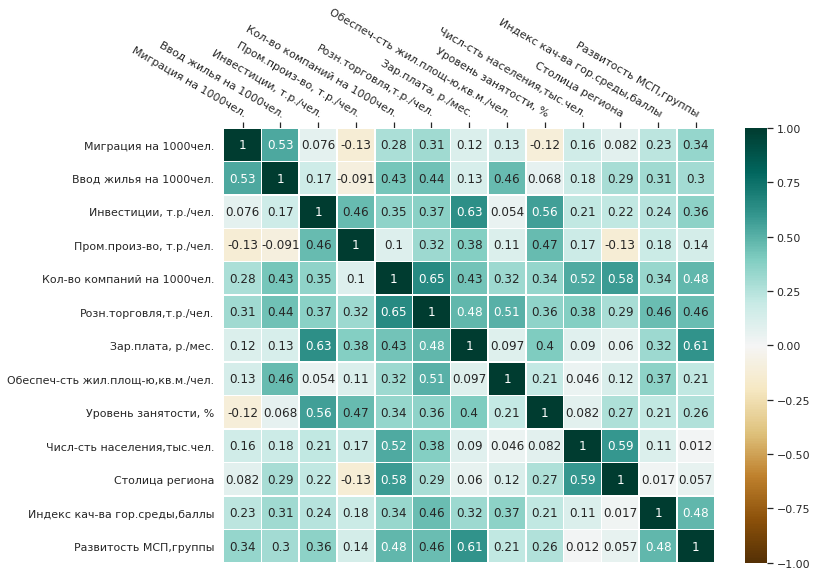

In [99]:
# Для выявления взаимосвязей пострим тепловую карту.

# Зададим размер.
sns.set(rc={'figure.figsize':(11,8)})


x = cities_growth[['migration_on1thnd', 
                   'accommod_on1thnd', 
                   'inv_thnds/prsn', 
                   'industry_thnds/prsn', 
                   'firms_on1thnd', 
                   'retail_thnds/prsn', 
                   'salary_RUBmnth', 
                   'sq.m_per_citizen', 
                   'employment_%', 
                   'population_thnds', 
                   'region_capital', 
                   'rating_urban', 
                   'rating_SME']]

# Создадим отдельный список для отображаемых названий.
elements = ['Миграция на 1000чел.', 
            'Ввод жилья на 1000чел.', 
            'Инвестиции, т.р./чел.', 
            'Пром.произ-во, т.р./чел.', 
            'Кол-во компаний на 1000чел.', 
            'Розн.торговля,т.р./чел.', 
            'Зар.плата, р./мес.', 
            'Обеспеч-сть жил.площ-ю,кв.м./чел.', 
            'Уровень занятости, %', 
            'Числ-сть населения,тыс.чел.', 
            'Столица региона', 
            'Индекс кач-ва гор.среды,баллы', 
            'Развитость МСП,группы']

ax = sns.heatmap(x.corr(method='spearman'), annot=True, vmin=-1, vmax=1, cmap='BrBG', linewidths=.5, 
           xticklabels=elements, 
           yticklabels=elements)

# Переносим подписи оси Х наверх.
ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)

# Меняем угол наклона подписей оси Х.
plt.setp(ax.get_xticklabels(), rotation=-30, ha='right',
         rotation_mode='anchor')

In [39]:
cities_growth.sort_values('employment_%', ascending=False)

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,employment_%,sq.m_per_citizen,population_thnds,rating_urban,rating_SME,region_capital,region1,region2,class_1,class_2
29,Салехард,9.100000,7.333333,689.200000,779.300000,79.033333,25.000000,53.000000,101979.666667,74.666667,24.300000,51.3,210,4,1,УФО,Ямало-Ненецкий автономный округ,Средние города (50-100тыс),Нефтегазовые города
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,38.333333,269.466667,65710.000000,72.333333,42.300000,137.2,177,4,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
134,Северодвинск,-1.700000,-2.066667,345.800000,16.800000,36.800000,15.333333,62.766667,59117.200000,69.300000,23.633333,183.0,188,3,0,СЗФО,Архангельская область,Большие города (100-500тыс),Остальные
57,Новый Уренгой,9.966667,3.766667,377.900000,240.033333,626.733333,27.666667,85.733333,111803.333333,67.933333,22.066667,118.0,180,4,0,УФО,Ямало-Ненецкий автономный округ,Большие города (100-500тыс),Нефтегазовые города
34,Санкт-Петербург,0.600000,6.666667,679.133333,137.333333,522.600000,58.333333,262.600000,60011.000000,67.400000,25.500000,5398.1,243,4,1,СЗФО,Санкт-Петербург,Миллионники (>1млн),Миллионники
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Новошахтинск,-6.233333,-0.700000,135.466667,5.966667,55.033333,5.666667,36.800000,23375.200000,19.933333,20.833333,106.6,122,1,0,ЮФО,Ростовская область,Большие города (100-500тыс),Южные города
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,18.333333,185.100000,56669.433333,18.533333,28.066667,507.4,204,3,0,ЦФО,Московская область,Крупнейшие города (500тыс-1млн),Часть крупной агломерации
104,Дербент,7.000000,0.166667,435.433333,7.733333,44.233333,8.666667,5.133333,25186.700000,16.433333,17.833333,125.8,158,1,0,СКФО,Республика Дагестан,Большие города (100-500тыс),Четвертая Россия
96,Хасавюрт,11.133333,0.666667,304.033333,5.000000,0.000000,10.666667,0.933333,23775.100000,14.400000,16.400000,145.1,146,1,0,СКФО,Республика Дагестан,Большие города (100-500тыс),Четвертая Россия


## 2.2 Миграция

### Карта

In [68]:
# Построим карту с городами на карте России.
# Данные о координатах (в десятичных градусах) возьмем в датасете settlements, города относятся к типу "г".

coords = settlements[settlements['type']=='г'][['region', 'settlement', 'latitude_dd', 'longitude_dd']]
coords

,region,settlement,latitude_dd,longitude_dd
id,,,,
295,Республика Саха (Якутия),Верхоянск,67.550000,133.383333
480,Калининградская область,Славск,55.043889,21.680000
692,Республика Татарстан,Мензелинск,55.720000,53.101389
693,Воронежская область,Семилуки,51.687222,39.027222
832,Калининградская область,Черняховск,54.630833,21.819444
...,...,...,...,...
155427,Московская область,Чехов,55.149722,37.466944
155464,Томская область,Асино,56.990833,86.176389
155551,Республика Татарстан,Мамадыш,55.715000,51.412778


In [69]:
# Проверяем на наличие дубликатов городов.
a = coords.groupby('settlement').count()
a[a['region']>1]

,region,latitude_dd,longitude_dd
settlement,,,
Белогорск,2,2,2
Березовский,2,2,2
Благовещенск,2,2,2
Великие Луки,2,2,2
Гурьевск,2,2,2
Джанкой,2,2,2
Железногорск,2,2,2
Заречный,2,2,2
Киров,2,2,2


In [70]:
# Убираем найденные дубликаты.
coords.drop_duplicates(subset = 'settlement', keep = 'first', inplace = True)
coords

,region,settlement,latitude_dd,longitude_dd
id,,,,
295,Республика Саха (Якутия),Верхоянск,67.550000,133.383333
480,Калининградская область,Славск,55.043889,21.680000
692,Республика Татарстан,Мензелинск,55.720000,53.101389
693,Воронежская область,Семилуки,51.687222,39.027222
832,Калининградская область,Черняховск,54.630833,21.819444
...,...,...,...,...
155308,Смоленская область,Починок,54.406389,32.439722
155427,Московская область,Чехов,55.149722,37.466944
155464,Томская область,Асино,56.990833,86.176389


In [73]:
# Добавим к базовому датасету cities_growth данные о координатах городов.

cities_coords = cities_growth.merge(coords, how='left', left_on='name', right_on='settlement')
cities_coords.head()

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,%mining,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,...,rating_urban,rating_SME,region_capital,region1,region2,class_1,region,settlement,latitude_dd,longitude_dd
0,Мытищи,1.133333,43.400000,1622.933333,102.400000,783.233333,0.0,46.333333,553.200000,59082.300000,...,227,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Мытищи,55.909444,37.733889
1,Красногорск,1.566667,42.266667,2977.200000,181.500000,412.833333,0.0,45.333333,301.666667,68119.666667,...,230,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Красногорск,55.831944,37.329444
2,Долгопрудный,-0.266667,35.366667,1057.966667,44.033333,236.100000,0.0,32.000000,99.366667,74811.233333,...,225,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Долгопрудный,55.933611,37.514444
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,0.0,18.333333,185.100000,56669.433333,...,204,3,0,ЦФО,Московская область,Крупнейшие города (500тыс-1млн),Московская область,Балашиха,55.796389,37.938333
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,0.0,38.333333,269.466667,65710.000000,...,177,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Домодедово,55.436944,37.767500


In [74]:
# Проверим у всех ли городов определились координаты.

cities_coords[pd.isna(cities_coords['latitude_dd'])]

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,%mining,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,...,rating_urban,rating_SME,region_capital,region1,region2,class_1,region,settlement,latitude_dd,longitude_dd
66,Уфа,1.133333,2.833333,605.500000,90.766667,784.000000,25.266667,41.000000,142.600000,46493.866667,...,182,3,1,ПФО,Республика Башкортостан,Миллионники (>1млн),NaN,NaN,NaN,NaN
106,Орехово- Зуево,-4.666667,0.066667,172.866667,17.733333,167.566667,0.000000,14.666667,142.466667,45543.433333,...,203,4,0,ЦФО,Московская область,Большие города (100-500тыс),NaN,NaN,NaN,NaN
139,Астрахань,0.633333,-2.300000,359.866667,159.600000,637.133333,81.766667,20.666667,81.933333,38073.933333,...,181,1,1,ЮФО,Астраханская область,Крупнейшие города (500тыс-1млн),NaN,NaN,NaN,NaN
163,Орел,-5.766667,-4.666667,315.433333,36.133333,166.666667,0.000000,28.333333,132.266667,32304.166667,...,177,1,1,ЦФО,Орловская область,Большие города (100-500тыс),NaN,NaN,NaN,NaN
177,Сергиев Посад,-3.400000,-10.533333,833.433333,36.933333,143.366667,0.000000,43.000000,180.966667,43938.933333,...,181,2,0,ЦФО,Московская область,Большие города (100-500тыс),NaN,NaN,NaN,NaN


In [78]:
# Подставим нужные координаты вручную через фильтр по индексу.

cities_coords.loc[66,['latitude_dd','longitude_dd']] = [54.743060,55.967790] # Уфа
cities_coords.loc[106,['latitude_dd','longitude_dd']] = [55.809167,38.978333] # Орехово-Зуево
cities_coords.loc[139,['latitude_dd','longitude_dd']] = [46.349680,48.040760] # Астрахань
cities_coords.loc[163,['latitude_dd','longitude_dd']] = [52.967222,36.069722] # Орел
cities_coords.loc[177,['latitude_dd','longitude_dd']] = [56.316111,38.134444] # Сергиев Посад

# Проверка.
cities_coords[pd.isna(cities_coords['latitude_dd'])]

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,%mining,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,...,rating_urban,rating_SME,region_capital,region1,region2,class_1,region,settlement,latitude_dd,longitude_dd


In [79]:
# Для построения карты используем библиотеку geopandas (подсказки: https://habr.com/ru/company/ods/blog/338554/).
# Карта России скачана здесь: https://mydata.biz/ru/catalog/databases/borders_ru

import geopandas as gpd

russia = gpd.read_file('Data/Maps/admin_level_3.shp', encoding='Windows-1251')
russia

,name,note,source,boundary,admin_leve,name_ca,name_de,name_en,name_es,name_fr,...,name_lt,populati_1,name_ja,name_pt,name_sv,name_vi,name_zh,int_name,timezone,geometry
0,урочище Ишмик,эксклав Ишмик,Яндекс,administrative,3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((38.72653 58.77856, 38.71925 58.77569..."
1,урочище Ишмик,эксклав Ишмик,Яндекс,administrative,3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((38.72653 58.77856, 38.71925 58.77569..."
2,Крымский федеральный округ,None,None,administrative,3,Districte Federal de Crimea,Foderationskreis Krim,Crimean Federal District,Distrito federal de Crimea,District federal de Crimee,...,None,None,None,None,None,None,None,None,None,"POLYGON ((36.68157 45.45661, 36.66350 45.35994..."
3,Уральский федеральный округ,None,None,administrative,3,Districte Federal dels Urals,Foderationskreis Ural,Ural Federal District,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((86.00729 64.27208, 86.00555 64.25572..."
4,Северо-Западный федеральный округ,None,None,administrative,3,Districte Federal del Nord-oest,Foderationskreis Nordwest,Northwestern Federal District,None,District federal du Nord-Ouest,...,Siaures-Vakaru federaline apskritis,2013-01-01,None,None,None,None,None,None,None,"MULTIPOLYGON (((37.97560 80.13514, 37.96434 80..."
5,урочище Ишмик,эксклав Ишмик,Яндекс,administrative,3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((38.72653 58.77856, 38.71925 58.77569..."
6,Приволжский федеральный округ,None,bing,administrative,3,Districte Federal del Volga,Foderationskreis Wolga,Volga Federal District,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((61.68956 51.25568, 61.56797 51.23773..."
7,Южный федеральный округ,None,None,administrative,3,Districte Federal del Sud,Foderationskreis Sudrussland,South federal district,None,District federal du Sud,...,None,None,??????,Distrito Federal do Sul,Sodra federala distriktet,Vung lien bang Phia Nam,??????,None,None,"POLYGON ((49.88612 46.04577, 49.61389 45.97476..."
8,Северо-Кавказский федеральный округ,None,None,administrative,3,Districte Federal del Caucas Nord,Foderationskreis Nordkaukasus,North Caucasus federal district,Distrito federal del Caucaso Norte,District federal du Caucase du Nord,...,None,None,??????????,Distrito Federal do Caucaso Norte,Nordkaukasiska federala distriktet,Vung lien bang B?c Kavkaz,????????,North Caucasus federal district,None,"POLYGON ((48.74516 41.99165, 48.81410 41.95029..."
9,Центральный федеральный округ,None,bing,administrative,3,Districte Federal Central,Foderationskreis Zentralrussland,Central Federal District,Distrito federal Central,District federal central,...,Centrine federaline apygarda,2015,None,Distrito Federal Central,None,None,None,Central Federal District,Europe/Moscow,"MULTIPOLYGON (((42.65859 54.55411, 42.65876 54..."


In [80]:
# Переделаем наш рабочий датафрейм cities_coords с координатами городов под формат geopandas.
# Для этого необходимо задать проекцию карты - Coordinate Reference Systems (параметр crs).
# 4326 соответствует координатам в десятичных градусах.
# (подсказка: https://stackoverflow.com/questions/61050942/make-geopandas-dataframe-from-points-then-project-the-gpd-got-error-cannot-tr)

geodf = gpd.GeoDataFrame(cities_coords, 
                         geometry=gpd.points_from_xy(cities_coords['longitude_dd'], cities_coords['latitude_dd']), 
                         crs='epsg:4326')
geodf.head()

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,%mining,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,...,rating_SME,region_capital,region1,region2,class_1,region,settlement,latitude_dd,longitude_dd,geometry
0,Мытищи,1.133333,43.400000,1622.933333,102.400000,783.233333,0.0,46.333333,553.200000,59082.300000,...,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Мытищи,55.909444,37.733889,POINT (37.73389 55.90944)
1,Красногорск,1.566667,42.266667,2977.200000,181.500000,412.833333,0.0,45.333333,301.666667,68119.666667,...,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Красногорск,55.831944,37.329444,POINT (37.32944 55.83194)
2,Долгопрудный,-0.266667,35.366667,1057.966667,44.033333,236.100000,0.0,32.000000,99.366667,74811.233333,...,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Долгопрудный,55.933611,37.514444,POINT (37.51444 55.93361)
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,0.0,18.333333,185.100000,56669.433333,...,3,0,ЦФО,Московская область,Крупнейшие города (500тыс-1млн),Московская область,Балашиха,55.796389,37.938333,POINT (37.93833 55.79639)
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,0.0,38.333333,269.466667,65710.000000,...,4,0,ЦФО,Московская область,Большие города (100-500тыс),Московская область,Домодедово,55.436944,37.767500,POINT (37.76750 55.43694)


In [81]:
# Проверим параметры проекции карты (crs) для карты России и городов.
# Для совмещения на одной карте координаты городов и карты России должны иметь одинаковый crs.
# (https://geopandas.org/docs/user_guide/mapping.html)

print(russia.crs)
print(geodf.crs)

epsg:4326
epsg:4326


In [82]:
# Для того, чтобы карта имела привычный вид, необходимо задать crs, используемый для карт России.
# Нашла, что epsg:3576 самый подходящий (https://epsg.io/3576).
# Зададим его для обоих датафреймов.

geodf = geodf.to_crs('epsg:3576')
russia = russia.to_crs('epsg:3576')

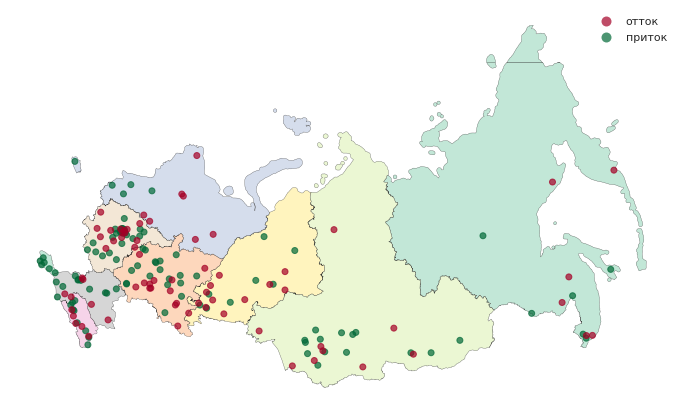

In [83]:
# Построим карту в несколько "слоев": 1ый слой - карта России, 2ой - города.

# Добавим столбец, где положительная миграций обозначена как "приток", отрицательная - "отток".
geodf['migr'] = ['отток' if x<=0 else 'приток' for x in geodf['migration_on1thnd']]

# 1ый слой - Россия.
ax = russia.plot(column='name', 
                 cmap='Pastel2', 
                 alpha=0.8, 
                 edgecolor='k', 
                 linewidth=0.3, 
                 figsize=(12, 9), 
                 legend=True, 
                 categorical=True, 
                 legend_kwds={'loc': 'lower center'})

# 2ой слой - города.
geodf.plot(ax=ax, 
           alpha=0.7, 
           column='migr', 
           cmap='RdYlGn', 
           legend=True, 
           legend_kwds={'edgecolor': 'white', 'facecolor': 'white'})

# Уберем оси с карты.
ax.set_axis_off()

### Столбчатая диаграмма по миграции в разрезе округов

In [85]:
# Добавим столбец 'positive', где миграционный приток будет обозначен цифрой 1.
total = cities_growth[['region1', 'migration_on1thnd']]
total.loc[total['migration_on1thnd']>0, 'positive'] = 1

# Сгруппируем данные по фед.округам, где будет отдельно указано всего городов в выборке 
# и в скольких из них миграционный приток.
data = total.groupby('region1').agg({'migration_on1thnd': 'count', 
                                     'positive': 'sum'}).sort_values('migration_on1thnd', 
                                                                     ascending=False).reset_index()

# В датасете города Мос.области представлены одной строкой,
# но для целей данной визуализации учтем их по отдельности.
# 15 городом МО имели положительный миграционный приток в 2017-2019 гг. 
# (см. вкладку "МО" в исходном файле "combined_data.xlsx")


# Доли городов с миграционным притоков в общем количестве городов фед.округа.
data['%'] = round(100 * data['positive'] / data['migration_on1thnd'], 0)

data

/home/ksenia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/ksenia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,region1,migration_on1thnd,positive,%
0,ЦФО,46,31.0,67.0
1,ПФО,32,19.0,59.0
2,ЮФО,23,17.0,74.0
3,СФО,20,11.0,55.0
4,УФО,20,8.0,40.0
5,ДФО,14,8.0,57.0
6,СКФО,14,9.0,64.0
7,СЗФО,12,5.0,42.0


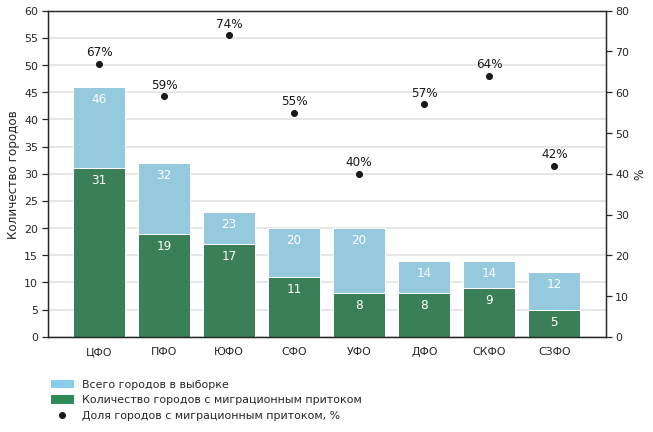

In [87]:
# Строим столбчатую диаграмму.

plt.figure(figsize=(10,6))

# Разметка по оси Y.
plt.grid(axis='y', color='k', linestyle='-', linewidth=0.2)

# Наносим столбцы: a - общее количество городов в фед.округе, b - из них с миграц.притоком.
a = sns.barplot(data=data, x='region1', y='migration_on1thnd', color='skyblue')
b = sns.barplot(data=data, x='region1', y='positive', color='seagreen')
a.set(xlabel='', ylabel='Количество городов')
a.set_yticks(range(0, 65, 5))
sns.set_style('white')

# Доли городов с миграционным притоком - вторая ось.
dots = a.twinx()
dots = sns.scatterplot(data=data, x='region1', y='%', color='k', marker='o')
    
# Легенда.
top_bar = mpatches.Patch(color='skyblue', label='Всего городов в выборке')
bottom_bar = mpatches.Patch(color='seagreen', label='Количество городов с миграционным притоком')
dot = plt.scatter(data=data, 
                  x='region1', y='%', 
                  color='k', marker='o', 
                  label='Доля городов с миграционным притоком, %')

plt.legend(handles=[top_bar, bottom_bar, dot], 
           loc='upper right', 
           bbox_to_anchor=(0.58, -0.1), 
           framealpha=0, 
           facecolor='white')

# Разметка правой оси Y.
dots.set_yticks(range(0, 85, 10))

# Наносим количество городов на соответствующие столбцы.
for p in b.patches:
    b.annotate(int(p.get_height()), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', 
               va = 'center', 
               size=12,
               xytext = (0, -12), 
               color='white', 
               textcoords = 'offset points')
    
# Наносим % городов с миграционным притоком.
for i in range(0, data.shape[0]):
    plt.text(x=data['region1'][i], 
             y=data['%'][i]+2, 
             s='{:.0f}%'.format(data['%'][i]), 
             c='k', 
             horizontalalignment='center')


### Южные города

In [165]:
# Показатели миграции и ввода жилья.
cities_growth[(cities_growth['region1']=='ЮФО')][['region2', 
                                                  'name', 
                                                  'migration_on1thnd', 
                                                  'accommod_on1thnd', 
                                                  'class_3']].sort_values('region2')

,region2,name,migration_on1thnd,accommod_on1thnd,class_3
139,Астраханская область,Астрахань,-2.300000,359.866667,C
99,Волгоградская область,Камышин,0.366667,81.766667,B
93,Волгоградская область,Волжский,0.800000,197.266667,B
91,Волгоградская область,Волгоград,0.900000,387.766667,B
7,Краснодарский край,Сочи,20.800000,491.566667,B
14,Краснодарский край,Краснодар,11.800000,2096.266667,A
128,Краснодарский край,Армавир,-1.633333,362.866667,C
24,Краснодарский край,Новороссийск,8.100000,783.433333,A
149,Республика Адыгея,Майкоп,-2.933333,249.133333,C
170,Республика Калмыкия,Элиста,-6.566667,799.833333,D


### Столицы

In [167]:
# Региональные столицы с положительной миграцией (минус Москва и С.-Петербург)
data = cities_growth[cities_growth['migration_on1thnd']>0]
data[data['region_capital']==1].count()['name']-2

54

### Нефтегазовые города

In [30]:
# Средний доход в городах ХМАО и ЯНАО.

cities_growth[(cities_growth['region2']=='Ямало-Ненецкий автономный округ')].mean()['salary_RUBmnth']/1000

101.38744444444444

In [31]:
# Средний доход по России.

cities_growth.mean()['salary_RUBmnth']/1000

44.26136261510127

### Группы миграционно привлекательных городов

In [12]:
# Создадим списки городов для дальнейшей аналитики.

# Список миллионников.
million = cities_growth[cities_growth['population_thnds']>1000]['name'].to_list()

# Список прочих региональных столиц (кроме миллионников).
regcap = cities_growth[(cities_growth['region_capital']==1) 
                       & (cities_growth['class_1']!='Миллионники (>1млн)')]['name'].to_list()

# Южные города.
south = cities_growth[(cities_growth['region1']=='ЮФО') 
                     | (cities_growth['region2']=='Ставропольский край') 
                     | (cities_growth['region2']=='Белгородская область')]['name'].to_list()

# "Ресурсные" города.
oil_gas = cities_growth[(cities_growth['region2']=='Ямало-Ненецкий автономный округ') 
             | (cities_growth['region2']=='Ханты-Мансийский автономный округ – Югра') 
             | (cities_growth['name']=='Якутск') 
             | (cities_growth['name']=='Южно-Сахалинск') 
             | (cities_growth['name']=='Альметьевск') 
             | (cities_growth['name']=='Ухта') 
             | (cities_growth['name']=='Астрахань')]['name'].to_list()

# Столицы (или большие города) республик Северного Кавказа, Калмыкии, Респ.Алтай и Тывы.
russia4 = cities_growth[(cities_growth['region1']=='СКФО') 
                        & (cities_growth['region2']!='Ставропольский край') 
                        | (cities_growth['region2']=='Республика Адыгея') 
                        | (cities_growth['region2']=='Республика Калмыкия')
                        | (cities_growth['region2']=='Республика Алтай') 
                        | (cities_growth['region2']=='Республика Тыва')]['name'].to_list()

# Города, входящие в некоторые успешные крупные городские агломерации:
# - города Московской области (Московская агломерация),
# - Батайск (Ростовская агломерация),
# - Бердск (Новосибирская агломерация),
# - на границе Московской и Калужской областей образовалась Обнинская агломерация,
# - Дзержинск (Нижегородская агломерация),
# - Новочебоксарск (Чебоксарская агломерация),
# - Энгельс (Саратовская агломерация).
agglomer = cities_growth[(cities_growth['region2']=='Московская область') 
                        | (cities_growth['name']=='Батайск') 
                        | (cities_growth['name']=='Бердск') 
                        | (cities_growth['name']=='Обнинск')
                        | (cities_growth['name']=='Дзержинск') 
                        | (cities_growth['name']=='Новочебоксарск') 
                        | (cities_growth['name']=='Энгельс')]['name'].to_list()

In [13]:
# Функция классифицирующая города с потенциалом роста.

def classification_2(row):
    
    # Миллионники.
    if row['name'] in million:
        return 'Миллионники'
    
    # Столицы (или большие города) республик Сев.Кавказа, Калмыкии, респ.Алтай, Тывы.
    elif row['name'] in russia4:
        return 'Четвертая Россия'
    
    # "Ресурсные" города.
    elif row['name'] in oil_gas:
        return 'Нефтегазовые города'
    
    # Южные города.
    elif row['name'] in south:
        return 'Южные города'
    
    # Города, входящие в некоторые крупные городские агломерации.
    elif row['name'] in agglomer:
        return 'Часть крупной агломерации'
    
    # Прочие региональные столицы.
    elif row['name'] in regcap:
        return 'Прочие региональные столицы'
    
    else:
        return 'Остальные'

In [14]:
cities_growth['class_2'] = cities_growth.apply(classification_2, axis=1)
cities_growth

,name,population_change,migration_on1thnd,accommod_on1thnd,inv_thnds/prsn,industry_thnds/prsn,firms_on1thnd,retail_thnds/prsn,salary_RUBmnth,employment_%,sq.m_per_citizen,population_thnds,rating_urban,rating_SME,region_capital,region1,region2,class_1,class_2
0,Мытищи,1.133333,43.400000,1622.933333,102.400000,783.233333,46.333333,553.200000,59082.300000,51.133333,28.900000,235.5,227,4,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
1,Красногорск,1.566667,42.266667,2977.200000,181.500000,412.833333,45.333333,301.666667,68119.666667,52.500000,35.266667,175.6,230,4,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
2,Долгопрудный,-0.266667,35.366667,1057.966667,44.033333,236.100000,32.000000,99.366667,74811.233333,26.700000,32.166667,116.0,225,4,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
3,Балашиха,4.633333,34.100000,793.233333,35.233333,122.300000,18.333333,185.100000,56669.433333,18.533333,28.066667,507.4,204,3,0,ЦФО,Московская область,Крупнейшие города (500тыс-1млн),Часть крупной агломерации
4,Домодедово,1.700000,30.600000,2398.666667,256.433333,236.333333,38.333333,269.466667,65710.000000,72.333333,42.300000,137.2,177,4,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Мурманск,-2.000000,-9.700000,41.100000,225.166667,347.300000,38.666667,134.066667,68016.033333,51.933333,24.133333,287.8,186,3,1,СЗФО,Мурманская область,Большие города (100-500тыс),Прочие региональные столицы
177,Сергиев Посад,-3.400000,-10.533333,833.433333,36.933333,143.366667,43.000000,180.966667,43938.933333,47.766667,34.433333,100.3,181,2,0,ЦФО,Московская область,Большие города (100-500тыс),Часть крупной агломерации
178,Находка,-3.566667,-10.666667,232.733333,113.400000,101.400000,32.000000,43.066667,51018.500000,40.166667,24.833333,146.0,160,2,0,ДФО,Приморский край,Большие города (100-500тыс),Остальные
179,Ухта,-1.300000,-13.933333,93.300000,323.966667,861.100000,20.333333,112.933333,62367.933333,51.666667,24.033333,113.7,187,4,0,СЗФО,Республика Коми,Большие города (100-500тыс),Нефтегазовые города


### График: миграция и ввод жилья

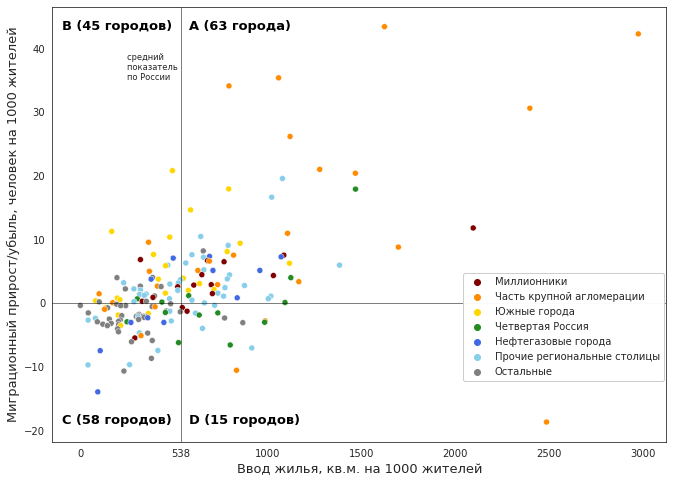

In [40]:
# Построим точечный график по 2м осям: миграция и ввод жилья.

plt.figure(figsize=(11,8))

# Точечный график разброса городов по 2м показателям.
hue_order = ['Миллионники', 
             'Часть крупной агломерации', 
             'Южные города', 
             'Четвертая Россия', 
             'Нефтегазовые города', 
             'Прочие региональные столицы', 
             'Остальные']
colors = {'Миллионники': 'maroon', 
         'Часть крупной агломерации': 'darkorange', 
         'Южные города': 'gold', 
         'Четвертая Россия': 'forestgreen', 
         'Нефтегазовые города': 'royalblue', 
         'Прочие региональные столицы': 'skyblue', 
         'Остальные': 'grey'}
ax = sns.scatterplot(data=cities_growth, x='accommod_on1thnd', y='migration_on1thnd', 
                     hue='class_2', hue_order=hue_order, palette=colors)

# Названия осей и легенда.
plt.xlabel('Ввод жилья, кв.м. на 1000 жителей', size=13)
plt.ylabel('Миграционный прирост/убыль, человек на 1000 жителей', size=13)
plt.legend(bbox_to_anchor=(0.66, 0.4), framealpha=10)

# Разделим города с миграционным притоком и оттоком.
plt.axhline(y=0, color='black', linewidth=0.5)

# Отметим среднее по показателю ввода жилья за 2017-2019 (https://rosstat.gov.ru/folder/14458).
plt.text(250, 35, 'средний \nпоказатель \nпо России', size='small')
plt.axvline(x=538, color='black', linewidth=0.5)
ax.set_xticks([0, 538, 1000, 1500, 2000, 2500, 3000])

# Задаем фон для графика.
sns.set_style('white')

# Введем обозначение для квадрантов.
# Количество городов в каждой группе рассчитано ниже.
plt.text(580, 43, 'A (63 города)', c='black', fontsize=13, fontweight='bold')
plt.text(-100, 43, 'B (45 городов)', c='black', fontsize=13, fontweight='bold')
plt.text(-100, -19, 'C (58 городов)', c='black', fontsize=13, fontweight='bold')
plt.text(580, -19, 'D (15 городов)', c='black', fontsize=13, fontweight='bold')

plt.show()

In [139]:
# Ведем классификацию по 2м критериям для датасета:
# A - миграционная прирост, ввод жилья выше среднего
# B - миграционная прирост, ввод жилья ниже среднего
# C - миграционная убыль, ввод жилья ниже среднего
# D - миграционная убыль, ввод жилья выше среднего

def classification_3(row):
    if (row['migration_on1thnd']>0) & (row['accommod_on1thnd']>538):
        return 'A'
    elif (row['migration_on1thnd']>0) & (row['accommod_on1thnd']<=538):
        return 'B'
    elif (row['migration_on1thnd']<=0) & (row['accommod_on1thnd']<=538):
        return 'C'
    elif (row['migration_on1thnd']<=0) & (row['accommod_on1thnd']>538):
        return 'D'

In [140]:
# Применим функцию и посмотрим, сколько городов оказалось в каждой группе.

cities_growth['class_3'] = cities_growth.apply(classification_3, axis=1)
cities_growth.groupby('class_3').count()['name']

class_3
A    63
B    45
C    58
D    15
Name: name, dtype: int64

In [141]:
# Чтобы визуализировать какие типы городов оказались в группах A, B, C, D,
# построим сводную таблицу и запишем ее в отдельную переменную.

groups_pt = cities_growth.pivot_table(index=['class_3', 'class_2'], values='name', aggfunc='count').reset_index()
groups_pt

,class_3,class_2,name
0,A,Миллионники,9
1,A,Нефтегазовые города,5
2,A,Остальные,1
3,A,Прочие региональные столицы,20
4,A,Часть крупной агломерации,15
5,A,Четвертая Россия,4
6,A,Южные города,9
7,B,Миллионники,4
8,B,Нефтегазовые города,2
9,B,Остальные,8


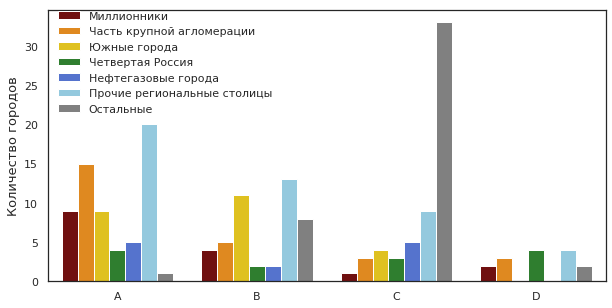

In [143]:
# Визуализация групп A, B, C, D по типам городов в них.

plt.figure(figsize=(10,5))

# Столбчатая диаграмма.
hue_order = ['Миллионники', 
             'Часть крупной агломерации', 
             'Южные города', 
             'Четвертая Россия', 
             'Нефтегазовые города', 
             'Прочие региональные столицы', 
             'Остальные']
colors = {'Миллионники': 'maroon', 
         'Часть крупной агломерации': 'darkorange', 
         'Южные города': 'gold', 
         'Четвертая Россия': 'forestgreen', 
         'Нефтегазовые города': 'royalblue', 
         'Прочие региональные столицы': 'skyblue', 
         'Остальные': 'grey'}
ax1 = sns.barplot(data=groups_pt, x='class_3', y='name', hue='class_2', 
                  hue_order=hue_order, 
                  palette=colors)

# Названия осей и легенда.
plt.xlabel('')
plt.ylabel('Количество городов', size=13)
plt.legend(loc='lower right', bbox_to_anchor=(0.42, 0.58), framealpha=0)


In [66]:
# Доля нестоличных городов с миграционным оттоком среди всех нестоличных городов
lost = cities_growth[(cities_growth['migration_on1thnd']<=0) 
                     & (cities_growth['region_capital']==0)].count()['name']
total = cities_growth[cities_growth['region_capital']==0].count()['name']

print('Нестоличные города с оттоком:', lost)
print('Всего нестоличных городов в выборке: ', total)

print('Доля с оттоком, %: ', round(100*lost/total))

Нестоличные города с оттоком: 49
Всего нестоличных городов в выборке:  101
Доля с оттоком, %:  49


# Приложение 2А

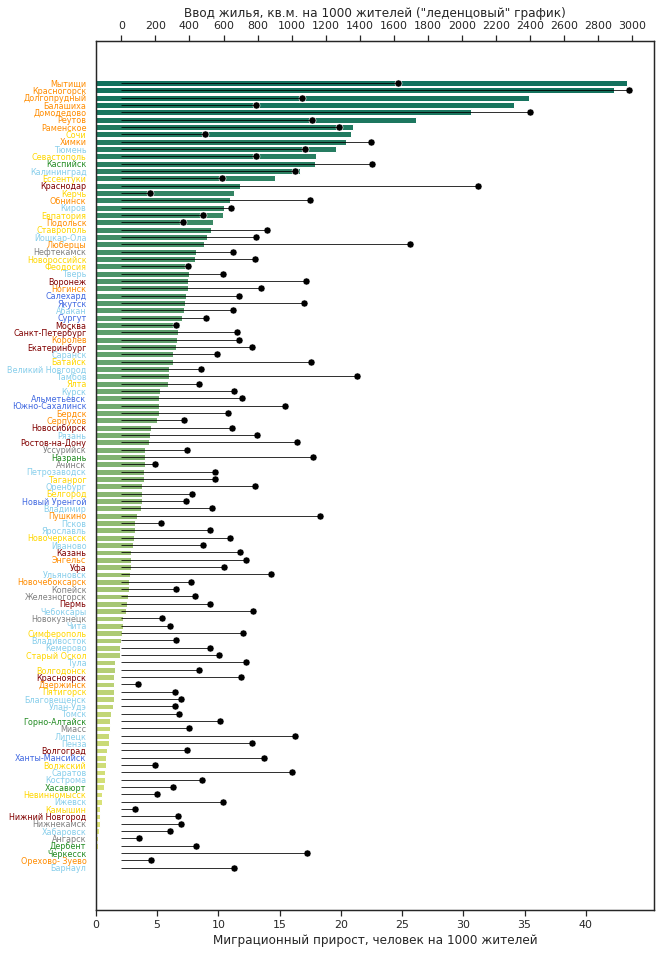

In [135]:
# Города с положительной миграцией - вариант 1.

plt.figure(figsize=(10,16))

data = cities_growth[cities_growth['migration_on1thnd']>0].sort_values(by='migration_on1thnd', 
                                                                       ascending=False).reset_index()

# Миграция - ось Х.
pal = sns.color_palette('summer', len(data))
rank = data['migration_on1thnd'].argsort().argsort()
ax1 = sns.barplot(data=data, y='name', x='migration_on1thnd', palette=np.array(pal[::-1])[rank], label='xx-small')
ax1.set(xlabel='Миграционный прирост, человек на 1000 жителей', ylabel='')
ax1.set_xticks(range(0, 45, 5))

# Размер шрифта для тиков оси Y.
ax1.set_yticklabels(ax1.get_yticks(), size = 8)

# Ввод жилья - вторая ось Х.
ax2 = ax1.twiny()
ax2 = sns.scatterplot(data=data, y='name', x='accommod_on1thnd', s=50, color='black')
ax2.set(xlabel='Ввод жилья, кв.м. на 1000 жителей ("леденцовый" график)')
ax2.set_xticks(range(0, 3200, 200))

# Выделим название города цветом по классификации 2 (миллионники, южные города, северный кавказ и т.д.).
for i in range(0, data.shape[0]):
    if data['class_2'][i]=='Миллионники':
        ax1.get_yticklabels()[i].set_color('maroon')
    elif data['class_2'][i]=='Часть крупной агломерации':
        ax1.get_yticklabels()[i].set_color('darkorange')
    elif data['class_2'][i]=='Южные города':
        ax1.get_yticklabels()[i].set_color('gold')
    elif data['class_2'][i]=='Четвертая Россия':
        ax1.get_yticklabels()[i].set_color('forestgreen')    
    elif data['class_2'][i]=='Нефтегазовые города':
        ax1.get_yticklabels()[i].set_color('royalblue')
    elif data['class_2'][i]=='Прочие региональные столицы':
        ax1.get_yticklabels()[i].set_color('skyblue')
    else:
        ax1.get_yticklabels()[i].set_color('grey')

# Дорисуем линии для лолипопа по вводу жилья.
plt.hlines(y=data['name'], xmin=0, xmax=data['accommod_on1thnd'], color='black', linewidth=0.8)

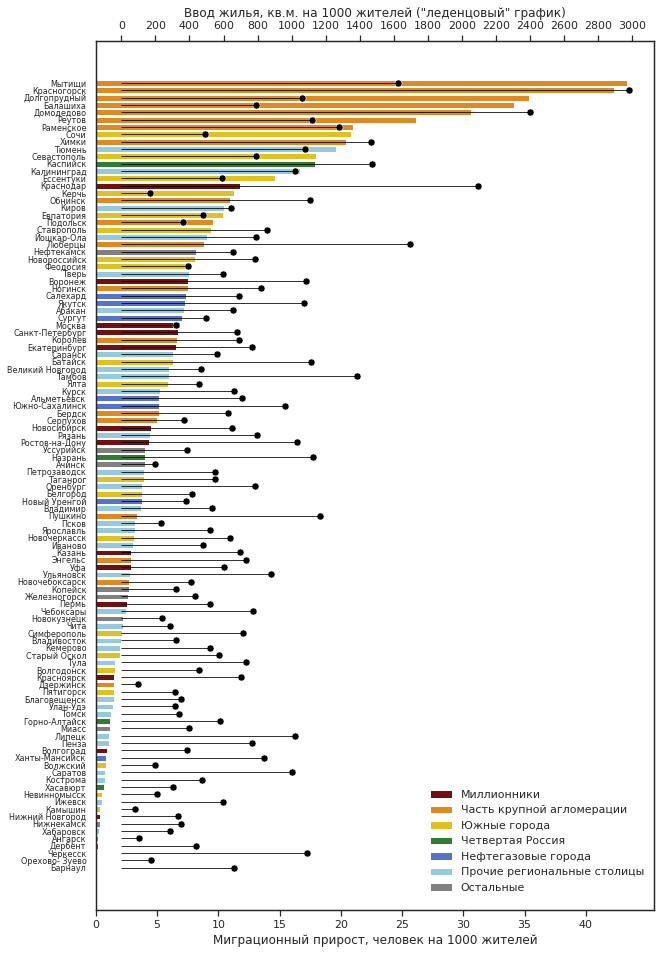

In [136]:
# Города с положительной миграцией - вариант 2.

plt.figure(figsize=(10,16))

data = cities_growth[cities_growth['migration_on1thnd']>0].sort_values(by='migration_on1thnd', 
                                                                       ascending=False).reset_index()

hue_order = ['Миллионники', 
             'Часть крупной агломерации', 
             'Южные города', 
             'Четвертая Россия', 
             'Нефтегазовые города', 
             'Прочие региональные столицы', 
             'Остальные']

colors = {'Миллионники': 'maroon', 
         'Часть крупной агломерации': 'darkorange', 
         'Южные города': 'gold', 
         'Четвертая Россия': 'forestgreen', 
         'Нефтегазовые города': 'royalblue', 
         'Прочие региональные столицы': 'skyblue', 
         'Остальные': 'grey'}

# Миграция - ось Х.
ax1 = sns.barplot(data=data, y='name', x='migration_on1thnd', 
                  dodge=False, hue='class_2', 
                  hue_order=hue_order, palette=colors)
ax1.set(xlabel='Миграционный прирост, человек на 1000 жителей', ylabel='')
ax1.set_xticks(range(0, 45, 5))
plt.legend(bbox_to_anchor=(1, 0.15), framealpha=0)

# Размер шрифта для тиков оси Y.
ax1.set_yticklabels(ax1.get_yticks(), size = 8)

# Ввод жилья - вторая ось Х.
ax2 = ax1.twiny()
ax2 = sns.scatterplot(data=data, y='name', x='accommod_on1thnd', s=50, color='black')
ax2.set(xlabel='Ввод жилья, кв.м. на 1000 жителей ("леденцовый" график)')
ax2.set_xticks(range(0, 3200, 200))

# Дорисуем линии для лолипопа по вводу жилья.
plt.hlines(y=data['name'], xmin=0, xmax=data['accommod_on1thnd'], color='black', linewidth=0.8)

# Приложение 2Б

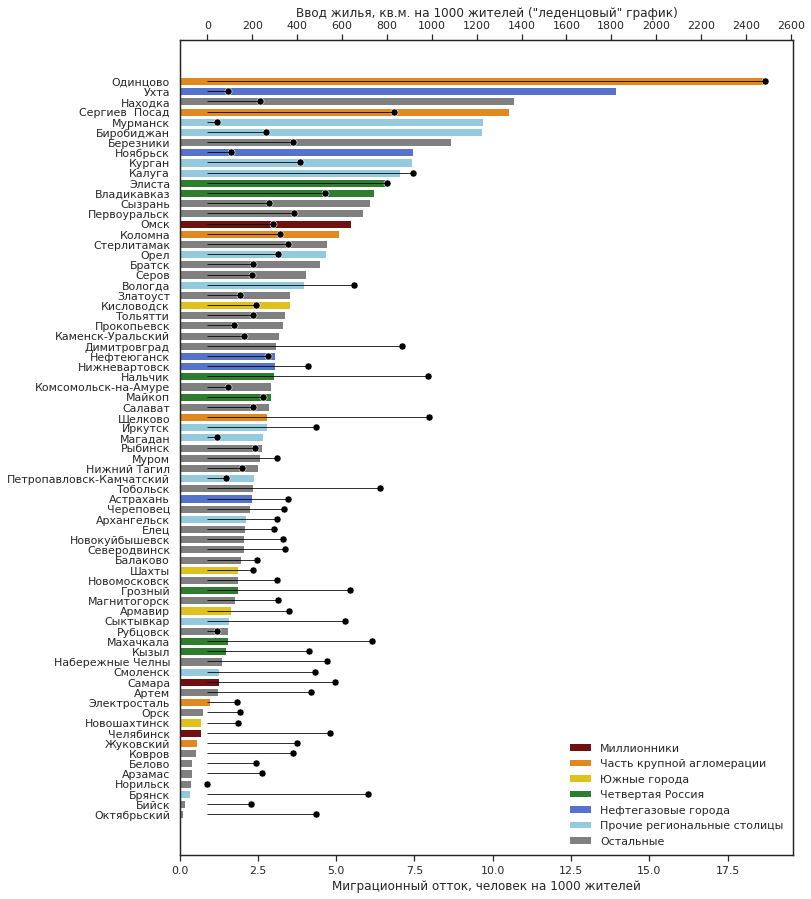

In [137]:
# Города с отрицательной миграцией.

plt.figure(figsize=(11,15))

hue_order = ['Миллионники', 
             'Часть крупной агломерации', 
             'Южные города', 
             'Четвертая Россия', 
             'Нефтегазовые города', 
             'Прочие региональные столицы', 
             'Остальные']

colors = {'Миллионники': 'maroon', 
         'Часть крупной агломерации': 'darkorange', 
         'Южные города': 'gold', 
         'Четвертая Россия': 'forestgreen', 
         'Нефтегазовые города': 'royalblue', 
         'Прочие региональные столицы': 'skyblue', 
         'Остальные': 'grey'}

data = cities_growth[cities_growth['migration_on1thnd']<=0].sort_values(by='migration_on1thnd').reset_index()

# Для удобства сопоставления осей "перевернем" негативную миграцию (отобразим с плюсом).
data['mirg_negative'] = -data['migration_on1thnd']

# Миграция - ось Х.
ax1 = sns.barplot(data=data, 
                  y='name', 
                  x='mirg_negative', 
                  dodge=False, 
                  hue='class_2', 
                  hue_order=hue_order, 
                  palette=colors) 
ax1.set(xlabel='Миграционный отток, человек на 1000 жителей', ylabel='')
plt.legend(bbox_to_anchor=(1, 0.15), framealpha=0)

# Ввод жилья - вторая ось Х.
ax2 = ax1.twiny()
ax2 = sns.scatterplot(data=data, y='name', x='accommod_on1thnd', s=50, color='black')
ax2.set(xlabel='Ввод жилья, кв.м. на 1000 жителей ("леденцовый" график)')
ax2.set_xticks(range(0, 3000, 200))

# Дорисуем линии для лолипопа по вводу жилья.
plt.hlines(y=data['name'], xmin=0, xmax=data['accommod_on1thnd'], color='black', linewidth=0.8)

# Приложение 3

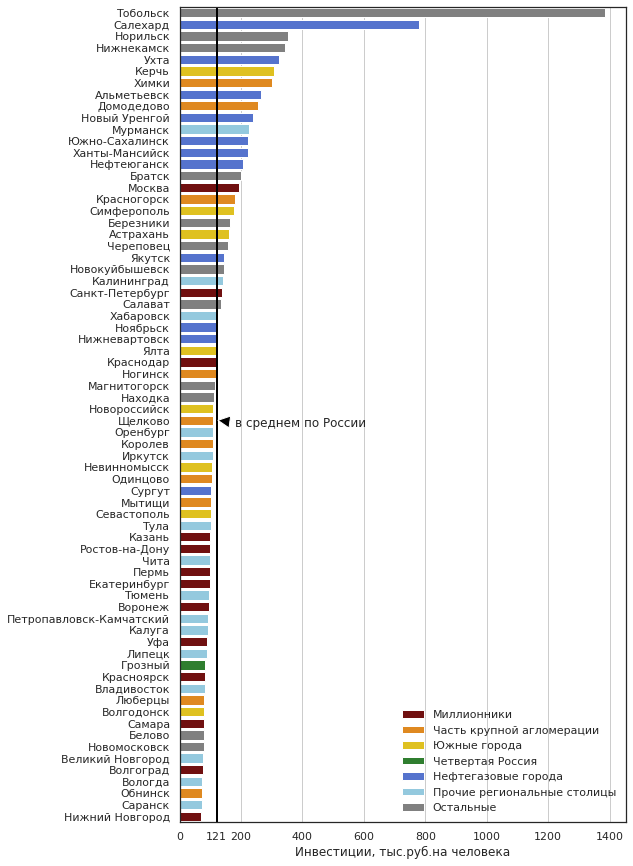

In [130]:
# Топ по инвестициям на душу населения.

# Среднероссийский уровень инвестиций, тыс.руб./чел.
avg_inv = 121

inv = cities_growth.sort_values(by='inv_thnds/prsn', ascending=False).reset_index().head(70)

plt.figure(figsize=(8,15))

ax2 = sns.barplot(data=inv, 
                  y='name', 
                  x='inv_thnds/prsn', 
                  dodge=False, 
                  hue='class_2', 
                  hue_order=hue_order, 
                  palette=colors)
ax2.set(xlabel='Инвестиции, тыс.руб.на человека', ylabel='')
plt.legend(bbox_to_anchor=(1, 0.15), framealpha=0)

# Среднедушевые инвестиции по РФ.
plt.axvline(x=avg_inv, color='black', linewidth=2)
ax2.set_xticks([0, 121, 200, 400, 600, 800, 1000, 1200, 1400])
ax2.annotate('в среднем по России', 
             xy=(125, 35), 
             xytext=(180, 35.5), 
             arrowprops=dict(facecolor='black', width=0.5))

# Разметка по оси Х.
plt.grid(axis='x')

# Выводы

 - Анализ миграции и девяти количественных (объемы ввода жилья на 1000 жителей, среднедушевые инвестиции, среднедушевое промышленное производство, среднедушевые объемы розничной торговли и проч.) и трех качественных показателей (является ли город столицей региона, индекс качества городской среды, уровень развития МСП) выявил устойчивую взаимосвязь только с одним параметром - объемами ввода жилья.  
  
  
 - Можно выделить следующие основные группы миграционно привлекательных городов:   
 1) столицы и их агломерации, куда в основном входят миллионники и другие региональные столицы и некоторые города, являющиеся частью успешных агломераций;  
 2) южные города;  
 3) нефтегазовые города;  
 4) "четвертая" Россия - республики Северного Кавказа, Алтай и Тыва, где не завершился 2ой демографический переход, неразвита экономика, сильна клановая система.  
 
 
 - Города, не являющиеся региональными столицами, проигрывают в конкуренции за жителей. Миграционный отток наблюдается во многих промышленных городах независимо от численности населения (например, Омск), а также в наиболее крупных столицах Северного Кавказа, несмотря на продолжающуюся там урбанизацию.